In [1]:
#!pip install scikit-learn --force
#!pip install catboost

In [2]:
import sys
sys.path.append('../..')
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd

pd.set_option('display.max.columns', 300)



from core.definitions import *

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
from core.models.utils import run_spark_session
spark = run_spark_session('write_t')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/29 22:07:41 WARN util.Utils: Service 'sparkDriver' could not bind on port 30240. Attempting port 30241.
23/10/29 22:07:41 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/10/29 22:07:43 WARN ipc.Client: Exception encountered while connecting to the server : org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.ipc.StandbyException): Operation category READ is not supported in state standby. Visit https://s.apache.org/sbnn-error
23/10/29 22:07:44 WARN ipc.Client: Exception encountered while connecting to the server : org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.ipc.StandbyException): Operation category READ is not supported in state standby. Visit https://s.apache.org/sbnn-error
23/10/29 22:07:45 WARN yarn.Client: Same path resource file:///opt/cloudera/parcels/AnacondaPy37/jars/spark-tree-plotting-0.

## Калькулятор маржи - Версия 2
### Расчет через вычисление маржи по месяцам

`agg_res` - используем как портфель  
`scenario_df` - используем для извлечения маржи  

Из всей суммы начисленных процентов выразим долю связанную с маржой и перемножим эту долю на начисленные проценты

Маржу рассчитываем из формулы по `weighted_rate`  

`VTB_weighted_rate_[segment]_[optionality]_[maturity] = VTB_ftp_rate_[maturity] - margin_[maturity] - SSV - FOR + optionality_spread + segment_spread`  

Откуда:  
`margin_[maturity] / VTB_weighted_rate_[segment]_[optionality]_[maturity] = (VTB_ftp_rate_[maturity] - SSV - FOR + optionality_spread + segment_spread) / VTB_weighted_rate_[segment]_[optionality]_[maturity] - 1`  


Умножаем interests на маржу для каждого:  
* сегмента  
* опциональности  
* срочности  

__!!!__ Подходит для flat-сценария, для боее гибкого стоит доработать исходя из перебора по

## Чтение ретро портфелей и создание выборки

In [4]:
BUCKETED_BALANCE_MAP_ = {
    1: '<100k',
    2: '100k-400k',
    3: '400k-1000k',
    4: '1000k-2000k',
    5: '>2000k'
}

In [5]:
portfolio_result_cols = [
    'report_dt', 'segment', 'replenishable_flg', 'subtraction_flg', 'month_maturity','target_maturity_days', 'bucketed_balance_nm', 'bucketed_balance', 'open_month', 'close_month', 
    'weight_rate', 'balance', 'renewal_cnt', 'operations_in_month', 'early_withdrawal_in_month', 'gen_name'
    ]

In [6]:
def _add_cols_to_port(port):
    port = port.copy()
    port.loc[:, 'replenishable_flg'] = port['optional_flg'].isin([2,3]).astype(int)
    port.loc[:, 'subtraction_flg'] = port['optional_flg'].isin([1,3]).astype(int)
    port.loc[:, 'segment'] = port['is_vip_or_prv'].apply(lambda x: SEGMENT_MAP_[x])
    port.loc[:, 'month_maturity'] =  (port['bucketed_period'] - 1).astype(int)
    port.loc[:, 'target_maturity_days'] =  port.month_maturity.apply(month_to_target_maturity) 
    return port

In [7]:
def _portfolio_result(port):
    port['bucketed_balance_nm'] = port.bucketed_balance.apply(
        lambda x: BUCKETED_BALANCE_MAP_[x] if x in BUCKETED_BALANCE_MAP_ else '<100k'
    )
    port.loc[:, 'renewal_cnt'] = port.weight_renewal_cnt.round()
    port.loc[:, 'operations_in_month'] = np.where(port.optional_flg > 0, port.SER_d_cl, 0)
    port.loc[:, 'early_withdrawal_in_month'] = np.where(port.optional_flg == 0, port.SER_d_cl, 0)
    port.loc[:, 'balance'] = port.loc[:, 'total_generation']

    #port = port[port['report_dt']>self._forecast_context.portfolio_dt+MonthEnd(-1)]
    return port.sort_values(
        by = ['report_dt', 'segment', 'replenishable_flg', 'subtraction_flg', 'balance'],ascending = [True, True, True, True, False], ignore_index = True
    )

In [8]:
# читаем фактические портфели

port_res = []

for i in range(1, 8, 1):
    #print(i)
    
    port = pd.read_csv(f'/home/vtb70186744/dynbalance/data/portfolio_data/portfolio_2023-0{i}.csv', parse_dates=True)
    port['report_dt'] = pd.to_datetime(port['report_dt'])

    port_res.append(port)

In [9]:
port.sum()['total_interests'] / 10**9

161.9616661517254

In [10]:
port.head()

,report_month,bucketed_balance,is_vip_or_prv,drop_flg,optional_flg,bucketed_period,open_month,close_month,bucketed_open_rate,report_dt,total_interests,remaining_interests,weight_rate,total_generation,total_generation_cleared,weight_renewal_cnt,weight_renewal_available_flg,weight_close_plan_day,gen_name,SER_d,SER_d_cl,SER_dinamic,SER_dinamic_cl,total_generation_lag1,total_generation_cl_lag1,CUR,report_weight_open_rate_1m,report_weight_open_rate_3m,report_weight_open_rate_6m,report_weight_open_rate_12m,report_weight_open_rate_24m,report_wo_period_weight_open_rate,init_total_generation,row_count,share_period_plan,max_total_generation,max_SER_dinamic
0,2023-07,1.0,0,NaN,3.0,25.0,2006-06,2024-06,1.0,2023-07-31,50.590822,8.29275,0.01,176824.42,176824.42,1.0,1.0,18.999929,2006-06_2024-06_1.0_25.0_1.0_3_0_RUR,1.45,1.45,0.000008,0.000008,176822.97,176822.97,RUR,NaN,NaN,NaN,NaN,NaN,NaN,176805.31,14,0.948897,176824.42,0.000008
1,2023-07,4.0,0,NaN,3.0,37.0,2009-06,2024-06,1.0,2023-07-31,347.708580,57.95143,0.01,1391169.32,1391169.32,1.0,1.0,16.000000,2009-06_2024-06_4.0_37.0_1.0_3_0_RUR,11.43,11.43,0.000008,0.000008,1391157.89,1391157.89,RUR,NaN,NaN,NaN,NaN,NaN,NaN,1390879.65,26,0.938675,1391169.32,0.000008
2,2023-07,4.0,0,NaN,3.0,19.0,2009-09,2024-10,1.0,2023-07-31,426.898800,71.14980,0.01,1670907.96,1670907.96,2.0,1.0,8.000000,2009-09_2024-10_4.0_19.0_1.0_3_0_RUR,13.73,13.73,0.000008,0.000008,1670894.23,1670894.23,RUR,NaN,NaN,NaN,NaN,NaN,NaN,1670866.31,4,0.916863,1670907.96,0.000008
3,2023-07,1.0,0,NaN,3.0,14.0,2012-08,2023-11,1.0,2023-07-31,8.193900,1.36565,0.01,32783.51,32783.51,2.0,1.0,30.000000,2012-08_2023-11_1.0_14.0_1.0_3_0_RUR,0.27,0.27,0.000008,0.000008,32783.24,32783.24,RUR,NaN,NaN,NaN,NaN,NaN,NaN,32781.10,10,0.970066,32783.51,0.000008
4,2023-07,1.0,1,NaN,3.0,25.0,2014-07,2024-07,4.0,2023-07-31,2550.000000,425.00000,2.50,30844.59,30844.59,4.0,1.0,21.000000,2014-07_2024-07_1.0_25.0_4.0_3_1_RUR,63.25,63.25,0.002055,0.002055,30781.34,30781.34,RUR,NaN,NaN,NaN,NaN,NaN,NaN,30464.95,7,0.899808,30844.59,0.002055


In [11]:
port_res = pd.concat(port_res).reset_index(drop=True)

In [12]:
port_res = _add_cols_to_port(port_res)

In [13]:
port_res = _portfolio_result(port_res)

In [14]:
port_res.head(3)

,report_month,bucketed_balance,is_vip_or_prv,drop_flg,optional_flg,bucketed_period,open_month,close_month,bucketed_open_rate,report_dt,total_interests,remaining_interests,weight_rate,total_generation,total_generation_cleared,weight_renewal_cnt,weight_renewal_available_flg,weight_close_plan_day,gen_name,SER_d,SER_d_cl,SER_dinamic,SER_dinamic_cl,total_generation_lag1,total_generation_cl_lag1,CUR,report_weight_open_rate_1m,report_weight_open_rate_3m,report_weight_open_rate_6m,report_weight_open_rate_12m,report_weight_open_rate_24m,report_wo_period_weight_open_rate,init_total_generation,row_count,share_period_plan,max_total_generation,max_SER_dinamic,replenishable_flg,subtraction_flg,segment,month_maturity,target_maturity_days,bucketed_balance_nm,renewal_cnt,operations_in_month,early_withdrawal_in_month,balance
0,2023-01,4.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.080998e+09,4.309770e+08,7.014158,3.767463e+10,3.689392e+10,0.0,0.0,7.640179,2022-09_2023-03_4.0_7.0_8.0_0_0_0.0_RUR,-1.498874e+08,-3.443082e+08,-0.003963,-0.009246,3.782452e+10,3.723822e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,4.033852e+10,5,0.674033,3.767463e+10,-0.003963,0,0,mass,6,180,1000k-2000k,0.0,0.0,-3.443082e+08,3.767463e+10
1,2023-01,3.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.039290e+09,4.140946e+08,7.014465,3.624522e+10,3.546236e+10,0.0,0.0,7.765046,2022-09_2023-03_3.0_7.0_8.0_0_0_0.0_RUR,4.100963e+07,-1.568994e+08,0.001133,-0.004405,3.620421e+10,3.561926e+10,RUR,NaN,7.0,7.490077,7.450225,NaN,7.355351,3.720755e+10,5,0.674033,3.624522e+10,0.001133,0,0,mass,6,180,400k-1000k,0.0,0.0,-1.568994e+08,3.624522e+10
2,2023-01,4.0,0,0.0,0.0,13.0,2022-09,2023-09,8.0,2023-01-31,7.430132e+08,1.515603e+09,7.000000,2.592414e+10,2.539205e+10,0.0,0.0,14.847356,2022-09_2023-09_4.0_13.0_8.0_0_0_0.0_RUR,-6.024040e+07,-1.934322e+08,-0.002318,-0.007560,2.598438e+10,2.558548e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,2.814998e+10,5,0.334247,2.592414e+10,-0.002318,0,0,mass,12,365,1000k-2000k,0.0,0.0,-1.934322e+08,2.592414e+10


In [15]:
port_res.groupby('report_dt').sum()['balance']

report_dt
2023-01-31    2.950907e+12
2023-02-28    3.000243e+12
2023-03-31    3.044367e+12
2023-04-30    3.077628e+12
2023-05-31    3.131640e+12
2023-06-30    3.148000e+12
2023-07-31    3.150017e+12
Name: balance, dtype: float64

In [16]:
port_res['interests'] = port_res['total_generation'] - port_res['total_generation_lag1'].astype(float) - port_res['SER_d_cl']

In [18]:
portfolio_res = port_res.copy()

In [19]:
portfolio_res['open_month_correct'] = pd.to_datetime(portfolio_res['open_month'], format='%Y-%m')

##### 

In [20]:
portfolio_res['target_maturity_days'].unique()

array([ 180,  365,   90, 1095,  548,  730])

In [21]:
maturity_dict = {90: 3,
                180: 6,
                365: 12,
                548: 18,
                730: 24,
                1095: 36}

In [22]:
# корректируем месяца
portfolio_res['target_maturity_months'] = portfolio_res['target_maturity_days'].replace(maturity_dict)

Сделаем поле open_month_correct и нормальную дату открытия для каждого депозита

In [23]:
portfolio_res.renewal_cnt.unique()

array([ 0.,  1.,  4.,  2.,  8.,  9.,  7.,  5.,  6.,  3., 10., 11., 12.])

<AxesSubplot:>

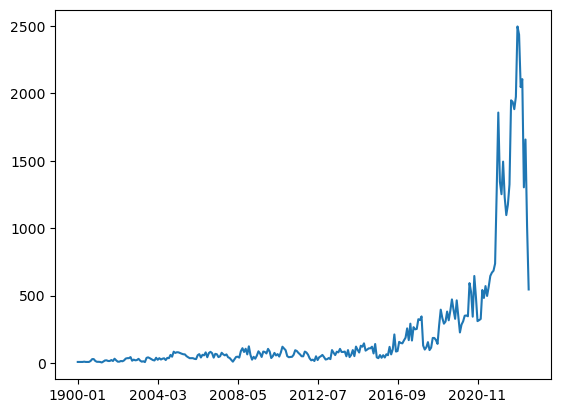

In [24]:
portfolio_res['open_month'].value_counts().sort_index().plot()

In [25]:
# 99 процентов занимают депозиты открытые позже 2017

portfolio_res[portfolio_res['open_month']>='2017-01']['balance'].sum() / portfolio_res['balance'].sum()

0.999803299013254

## Корректируем дату открытия относительно даты закрытия для депозитов с пролонгацией

In [26]:
portfolio_res.groupby('report_month').sum()['balance']

report_month
2023-01    2.950907e+12
2023-02    3.000243e+12
2023-03    3.044367e+12
2023-04    3.077628e+12
2023-05    3.131640e+12
2023-06    3.148000e+12
2023-07    3.150017e+12
Name: balance, dtype: float64

In [28]:
portfolio_res[portfolio_res['renewal_cnt']>0][['open_month', 'close_month', 'month_maturity', 'renewal_cnt']]

,open_month,close_month,month_maturity,renewal_cnt
29,2022-10,2023-04,3,1.0
36,2022-10,2023-04,3,1.0
76,2022-10,2023-04,3,1.0
88,2022-09,2023-03,3,1.0
94,2022-09,2023-03,3,1.0
...,...,...,...,...
64308,2014-12,2023-12,12,2.0
64309,2015-02,2024-02,12,2.0
64310,2009-11,2023-12,12,2.0
64311,2019-05,2025-06,36,1.0


 Формула расчета даты открытия к которой будет происходить джойн для депозитов где renewal_cnt>0: `дата закрытия` - `month_maturity`

In [29]:
portfolio_res['close_month_dt'] = pd.to_datetime(portfolio_res['close_month']) 

In [30]:
portfolio_res['open_month_correct'] = pd.to_datetime(portfolio_res['open_month']) 

In [31]:
portfolio_res['target_maturity_months'].unique()

array([ 6, 12,  3, 36, 18, 24])

In [32]:
portfolio_res.groupby('report_month').sum()['balance']

report_month
2023-01    2.950907e+12
2023-02    3.000243e+12
2023-03    3.044367e+12
2023-04    3.077628e+12
2023-05    3.131640e+12
2023-06    3.148000e+12
2023-07    3.150017e+12
Name: balance, dtype: float64

In [33]:
for mat in portfolio_res['target_maturity_months'].unique():
    
    portfolio_res['open_month_correct'][(portfolio_res['renewal_cnt']>0)&(portfolio_res['target_maturity_months']==mat)] = \
    portfolio_res['close_month_dt'][(portfolio_res['renewal_cnt']>0)&(portfolio_res['target_maturity_months']==mat)] +  MonthEnd(-mat)
    
    
    portfolio_res['open_month'][(portfolio_res['renewal_cnt']>0)&(portfolio_res['target_maturity_months']==mat)] = \
    portfolio_res['open_month_correct'][(portfolio_res['renewal_cnt']>0)&(portfolio_res['target_maturity_months']==mat)].apply(lambda x: str(x)[:7])

In [34]:
portfolio_res.groupby('report_month').sum()['balance']

report_month
2023-01    2.950907e+12
2023-02    3.000243e+12
2023-03    3.044367e+12
2023-04    3.077628e+12
2023-05    3.131640e+12
2023-06    3.148000e+12
2023-07    3.150017e+12
Name: balance, dtype: float64

<AxesSubplot:>

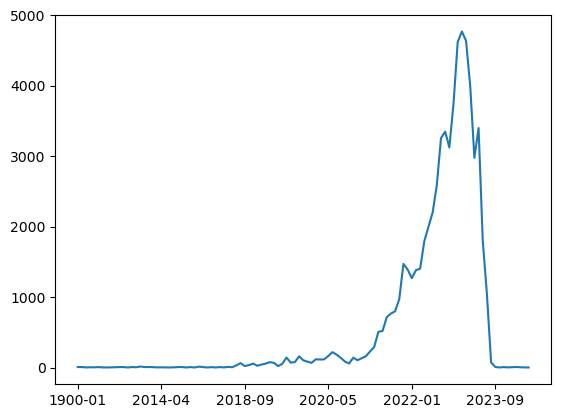

In [35]:
portfolio_res['open_month'].value_counts().sort_index().plot()

## Парсим спреды и джойним их

Попробуем использовать спреды за опциональность для вычетания со срочностей

In [36]:
import pip

In [37]:
pip.main(['install', 'openpyxl'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Looking in indexes: http://nxrm:8081/repository/pypi/simple

Requirement already satisfied: openpyxl in /tmp/envs/hmelevskoi_env/lib/python3.7/site-packages (3.1.2)

Requirement already satisfied: et-xmlfile in /tmp/envs/hmelevskoi_env/lib/python3.7/site-packages (from openpyxl) (1.1.0)

0

In [38]:
spreads = pd.read_excel('spreads_deposits.xlsx')

In [39]:
#spreads['Дата'] = spreads['Дата'].dt.to_period('M')
spreads = spreads[spreads['Валюта']=='RUB']

In [40]:
spreads_list = ['Спред по депозитам ФЛ с правом пополнения',
                'Спред по депозитам ФЛ с правом пополнения и досрочного частичного снятия до суммы неснижаемого остатка']

## Спред на момент выдачи или на момент расчета?

In [41]:
spreads = spreads[spreads['Инструмент'].isin(spreads_list)]

In [42]:
spreads.columns

Index(['Дата', 'Валюта', 'Инструмент', '2 недели (14 дней)',
       '3 недели (21 день)', '1 месяц (31 день)', '2 месяца (61 день)',
       '3 месяца (91 день)', '6 месяцев (181 день)', '9 месяцев (271 день)',
       '1 год (365 дней)', '1,5 года (548 дней)', '2 года (731 день)',
       '3 года (1095 дней)', '4 года (1461 день)', '5 лет (1830 дней)',
       'Комментарий', 'Обозначение инструмента',
       'Обозначение базиса плавающей ставки'],
      dtype='object')

In [43]:
drop_cols = ['Валюта', 
             'Комментарий', 
             'Обозначение инструмента',
             'Обозначение базиса плавающей ставки',
             '4 года (1461 день)', 
             '5 лет (1830 дней)',
             '2 недели (14 дней)', 
             '3 недели (21 день)',
             '1 месяц (31 день)', 
             '2 месяца (61 день)',
             '9 месяцев (271 день)']

In [44]:
spreads.drop(columns=drop_cols, inplace=True)

In [45]:
spreads_maturity_dict = {'3 месяца (91 день)': '90_spread',
                '6 месяцев (181 день)': '180_spread',
                '1 год (365 дней)': '365_spread',
                '1,5 года (548 дней)': '548_spread',
                '2 года (731 день)': '730_spread',
                '3 года (1095 дней)': '1095_spread'}

In [46]:
spreads.rename(columns=spreads_maturity_dict, inplace=True)

In [47]:
spreads['Инструмент'].unique()

array(['Спред по депозитам ФЛ с правом пополнения',
       'Спред по депозитам ФЛ с правом пополнения и досрочного частичного снятия до суммы неснижаемого остатка'],
      dtype=object)

r - буква, которая означает возможность пополнения вкладов (r1 - опция есть, r0 - опции нет). Происхождение: r от слова replenishable  
s - буква, которая означает возможность расходных операций вкладов (s1 - опция есть, s0 - опции нет). Происхождение: s от слова subtraction  

In [48]:
spreads.loc[:, 'replenishable_flg'] = spreads['Инструмент'].isin(['Спред по депозитам ФЛ с правом пополнения', 'Спред по депозитам ФЛ с правом пополнения и досрочного частичного снятия до суммы неснижаемого остатка']).astype(int)
spreads.loc[:, 'subtraction_flg'] = spreads['Инструмент'].isin(['Спред по депозитам ФЛ с правом пополнения и досрочного частичного снятия до суммы неснижаемого остатка']).astype(int)

## ПОДГОТОВИМ ДЛЯ ЗАПИСИ

In [49]:
spreads_tmp = spreads.rename(columns={'Дата': 'date'})

In [50]:
spreads_tmp.head()

,date,Инструмент,90_spread,180_spread,365_spread,548_spread,730_spread,1095_spread,replenishable_flg,subtraction_flg
0,2023-09-18,Спред по депозитам ФЛ с правом пополнения,0.0057,0.0089,0.0143,0.0147,0.0150,0.0158,1,0
2,2023-09-18,Спред по депозитам ФЛ с правом пополнения и до...,0.0073,0.0111,0.0171,0.0178,0.0186,0.0198,1,1
6,2023-08-15,Спред по депозитам ФЛ с правом пополнения,0.0050,0.0078,0.0129,0.0142,0.0154,0.0156,1,0
8,2023-08-15,Спред по депозитам ФЛ с правом пополнения и до...,0.0065,0.0098,0.0156,0.0175,0.0193,0.0195,1,1
12,2023-07-24,Спред по депозитам ФЛ с правом пополнения,0.0029,0.0048,0.0089,0.0095,0.0101,0.0106,1,0


In [51]:
spreads_tmp_s0 = spreads_tmp[spreads_tmp['subtraction_flg']==0]
spreads_tmp_s1 = spreads_tmp[spreads_tmp['subtraction_flg']==1]

In [52]:
dates = pd.date_range(start='2005-01-01', end='2023-09-01')

In [53]:
dates = pd.DataFrame(dates)

In [54]:
dates.rename(columns={0: 'date'}, inplace=True)

In [55]:
spreads_tmp_s0 = dates.merge(spreads_tmp_s0, on='date', how='left').sort_values(by='date', ascending=False).fillna(method='bfill').dropna()

In [56]:
del spreads_tmp_s0['Инструмент']

In [57]:
spreads_tmp_s1 = dates.merge(spreads_tmp_s1, on='date', how='left').sort_values(by='date', ascending=False).fillna(method='bfill').dropna()

In [58]:
del spreads_tmp_s1['Инструмент']

In [59]:
spreads_tmp_s0.shape

(2070, 9)

In [60]:
spreads_tmp_s1.shape

(2070, 9)

In [61]:
2957524528391.21000 / 10**9

2957.52452839121

In [62]:
spreads_tmp_final = spreads_tmp_s0.append(spreads_tmp_s1)
spreads_tmp_final

,date,90_spread,180_spread,365_spread,548_spread,730_spread,1095_spread,replenishable_flg,subtraction_flg
6817,2023-09-01,0.0050,0.0078,0.0129,0.0142,0.0154,0.0156,1.0,0.0
6816,2023-08-31,0.0050,0.0078,0.0129,0.0142,0.0154,0.0156,1.0,0.0
6815,2023-08-30,0.0050,0.0078,0.0129,0.0142,0.0154,0.0156,1.0,0.0
6814,2023-08-29,0.0050,0.0078,0.0129,0.0142,0.0154,0.0156,1.0,0.0
6813,2023-08-28,0.0050,0.0078,0.0129,0.0142,0.0154,0.0156,1.0,0.0
...,...,...,...,...,...,...,...,...,...
4752,2018-01-05,0.0045,0.0062,0.0091,0.0105,0.0119,0.0136,1.0,1.0
4751,2018-01-04,0.0045,0.0062,0.0091,0.0105,0.0119,0.0136,1.0,1.0
4750,2018-01-03,0.0045,0.0062,0.0091,0.0105,0.0119,0.0136,1.0,1.0
4749,2018-01-02,0.0045,0.0062,0.0091,0.0105,0.0119,0.0136,1.0,1.0


In [63]:
#sparkDF = spark.createDataFrame(spreads_tmp_final)

In [64]:
#sparkDF.write.mode('overwrite').saveAsTable('dadm_alm_sbx.vtb_spreads_deposits')

In [65]:
#spark.catalog.refreshTable('dadm_alm_sbx.vtb_spreads_deposits')

## Продолжаем

In [66]:
spreads['open_month'] = spreads['Дата'].apply(lambda x: str(x)[:7])

In [67]:
portfolio_res.head(3)

,report_month,bucketed_balance,is_vip_or_prv,drop_flg,optional_flg,bucketed_period,open_month,close_month,bucketed_open_rate,report_dt,total_interests,remaining_interests,weight_rate,total_generation,total_generation_cleared,weight_renewal_cnt,weight_renewal_available_flg,weight_close_plan_day,gen_name,SER_d,SER_d_cl,SER_dinamic,SER_dinamic_cl,total_generation_lag1,total_generation_cl_lag1,CUR,report_weight_open_rate_1m,report_weight_open_rate_3m,report_weight_open_rate_6m,report_weight_open_rate_12m,report_weight_open_rate_24m,report_wo_period_weight_open_rate,init_total_generation,row_count,share_period_plan,max_total_generation,max_SER_dinamic,replenishable_flg,subtraction_flg,segment,month_maturity,target_maturity_days,bucketed_balance_nm,renewal_cnt,operations_in_month,early_withdrawal_in_month,balance,interests,open_month_correct,target_maturity_months,close_month_dt
0,2023-01,4.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.080998e+09,4.309770e+08,7.014158,3.767463e+10,3.689392e+10,0.0,0.0,7.640179,2022-09_2023-03_4.0_7.0_8.0_0_0_0.0_RUR,-1.498874e+08,-3.443082e+08,-0.003963,-0.009246,3.782452e+10,3.723822e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,4.033852e+10,5,0.674033,3.767463e+10,-0.003963,0,0,mass,6,180,1000k-2000k,0.0,0.0,-3.443082e+08,3.767463e+10,1.944209e+08,2022-09-01,6,2023-03-01
1,2023-01,3.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.039290e+09,4.140946e+08,7.014465,3.624522e+10,3.546236e+10,0.0,0.0,7.765046,2022-09_2023-03_3.0_7.0_8.0_0_0_0.0_RUR,4.100963e+07,-1.568994e+08,0.001133,-0.004405,3.620421e+10,3.561926e+10,RUR,NaN,7.0,7.490077,7.450225,NaN,7.355351,3.720755e+10,5,0.674033,3.624522e+10,0.001133,0,0,mass,6,180,400k-1000k,0.0,0.0,-1.568994e+08,3.624522e+10,1.979090e+08,2022-09-01,6,2023-03-01
2,2023-01,4.0,0,0.0,0.0,13.0,2022-09,2023-09,8.0,2023-01-31,7.430132e+08,1.515603e+09,7.000000,2.592414e+10,2.539205e+10,0.0,0.0,14.847356,2022-09_2023-09_4.0_13.0_8.0_0_0_0.0_RUR,-6.024040e+07,-1.934322e+08,-0.002318,-0.007560,2.598438e+10,2.558548e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,2.814998e+10,5,0.334247,2.592414e+10,-0.002318,0,0,mass,12,365,1000k-2000k,0.0,0.0,-1.934322e+08,2.592414e+10,1.331918e+08,2022-09-01,12,2023-09-01


In [68]:
spreads.columns

Index(['Дата', 'Инструмент', '90_spread', '180_spread', '365_spread',
       '548_spread', '730_spread', '1095_spread', 'replenishable_flg',
       'subtraction_flg', 'open_month'],
      dtype='object')

In [69]:
spreads = spreads[['90_spread', 
                   '180_spread', 
                   '365_spread',
                   '548_spread', 
                   '730_spread', 
                   '1095_spread', 
                   'replenishable_flg',
                   'subtraction_flg', 
                   'open_month']]

In [70]:
np.sort(spreads['open_month'].unique())

array(['2018-01', '2018-05', '2018-10', '2019-03', '2019-06', '2019-09',
       '2020-03', '2020-05', '2020-07', '2020-10', '2021-02', '2021-03',
       '2021-05', '2021-06', '2021-08', '2021-09', '2021-10', '2021-11',
       '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05',
       '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2023-05',
       '2023-06', '2023-07', '2023-08', '2023-09'], dtype=object)

In [71]:
years = range(2018, 2024, 1)
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


dates_list = []
for year in years:
    for month in months:
        date = str(year) + '-' + month
        dates_list.append(date)

In [72]:
spreads.index = pd.MultiIndex.from_frame(spreads[['subtraction_flg', 'open_month']])

In [73]:
spreads = spreads.drop(columns=['subtraction_flg', 'open_month'])

In [74]:
cols_sp = list(spreads.columns)

In [75]:
for i, date in enumerate(dates_list):
    for sub in [0,1]:
        if (sub, date) not in spreads.index:
            #print((sub, date))
            spreads.loc[(sub, date), cols_sp] = spreads.loc[sub, dates_list[i-1]].reset_index()[cols_sp].values[0].tolist()

In [76]:
spreads = spreads.reset_index()

In [77]:
len(dates_list)/2/12

3.0

In [78]:
spreads.groupby('open_month').count()

,subtraction_flg,90_spread,180_spread,365_spread,548_spread,730_spread,1095_spread,replenishable_flg
open_month,,,,,,,,
2018-01,2,2,2,2,2,2,2,2
2018-02,2,2,2,2,2,2,2,2
2018-03,2,2,2,2,2,2,2,2
2018-04,2,2,2,2,2,2,2,2
2018-05,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...
2023-08,2,2,2,2,2,2,2,2
2023-09,2,2,2,2,2,2,2,2
2023-10,2,2,2,2,2,2,2,2


In [79]:
spreads['replenishable_flg'] = spreads['replenishable_flg'].astype(int)

In [80]:
portfolio_res.groupby('report_month').sum()['balance']

report_month
2023-01    2.950907e+12
2023-02    3.000243e+12
2023-03    3.044367e+12
2023-04    3.077628e+12
2023-05    3.131640e+12
2023-06    3.148000e+12
2023-07    3.150017e+12
Name: balance, dtype: float64

In [81]:
spreads = spreads.drop_duplicates(subset=['open_month', 'subtraction_flg', 'replenishable_flg'])

In [82]:
portfolio_res = portfolio_res.merge(spreads, on=['replenishable_flg', 'subtraction_flg', 'open_month'], how='left')

In [83]:
portfolio_res.groupby('report_month').sum()['balance']

report_month
2023-01    2.950907e+12
2023-02    3.000243e+12
2023-03    3.044367e+12
2023-04    3.077628e+12
2023-05    3.131640e+12
2023-06    3.148000e+12
2023-07    3.150017e+12
Name: balance, dtype: float64

In [84]:
portfolio_res['target_maturity_days'].unique()

array([ 180,  365,   90, 1095,  548,  730])

In [85]:
portfolio_res['spreads_mat'] = np.nan

for day in portfolio_res['target_maturity_days'].unique():
    
    # выбираем колонку
    col = f'{day}_spread'
    
    portfolio_res['spreads_mat'][portfolio_res['target_maturity_days']==day] = portfolio_res[col][portfolio_res['target_maturity_days']==day]

In [86]:
# проверить количество пропусков тут

In [87]:
portfolio_res['spreads_mat'] = portfolio_res['spreads_mat'].fillna(0)*100

In [88]:
portfolio_res['spreads_mat'].describe()

count    64313.000000
mean         0.378100
std          0.468541
min          0.000000
25%          0.000000
50%          0.370000
75%          0.640000
max          2.250000
Name: spreads_mat, dtype: float64

## Джойн FTP ставок

In [89]:
# Код выгрузки

query = """
SELECT 
year(report_date) as report_year, 
month(report_date) as report_month, 
AVG(`vtb_[1095d]_ftp_rate`) as `VTB_[1095d]_ftp_rate`, 
AVG(`vtb_[180d]_ftp_rate`) as `VTB_[180d]_ftp_rate`,
AVG(`vtb_[365d]_ftp_rate`) as `VTB_[365d]_ftp_rate`,
AVG(`vtb_[548d]_ftp_rate`) as `VTB_[548d]_ftp_rate`,
AVG(`vtb_[730d]_ftp_rate`) as `VTB_[730d]_ftp_rate`,
AVG(`vtb_[90d]_ftp_rate`) as `VTB_[90d]_ftp_rate`

FROM dadm_alm_sbx.vtb_ftp_rates 

GROUP BY year(report_date), month(report_date)
ORDER BY year(report_date) desc, month(report_date) desc;
"""

In [90]:
ftp_table = pd.read_csv('ftp.csv')

In [91]:
ftp_table[(ftp_table['report_year']==2022)&(ftp_table['report_month']==9)]

,report_year,report_month,vtb_[1095d]_ftp_rate,vtb_[180d]_ftp_rate,vtb_[365d]_ftp_rate,vtb_[548d]_ftp_rate,vtb_[730d]_ftp_rate,vtb_[90d]_ftp_rate
12,2022,9,8.25,7.891304,8.0,8.1,8.15,7.847826


In [92]:
ftp_table[(ftp_table['report_year']==2022)&(ftp_table['report_month']==8)]

,report_year,report_month,vtb_[1095d]_ftp_rate,vtb_[180d]_ftp_rate,vtb_[365d]_ftp_rate,vtb_[548d]_ftp_rate,vtb_[730d]_ftp_rate,vtb_[90d]_ftp_rate
13,2022,8,8.25,8.0,8.0,8.1,8.15,8.0


In [93]:
2543021883347.37000 / 10**9

2543.02188334737

## Корректируем ставку за февраль 2022 в связи с резкими притоками

In [94]:
ind = ftp_table[(ftp_table['report_year']==2022)&(ftp_table['report_month']==2)].index

In [95]:
cols = ftp_table.columns[2:]

In [96]:
cols

Index(['vtb_[1095d]_ftp_rate', 'vtb_[180d]_ftp_rate', 'vtb_[365d]_ftp_rate',
       'vtb_[548d]_ftp_rate', 'vtb_[730d]_ftp_rate', 'vtb_[90d]_ftp_rate'],
      dtype='object')

In [97]:
w1 = 5
w2 = 1

In [98]:
new_ftp = ((ftp_table[(ftp_table['report_year']==2022)&(ftp_table['report_month']==2)][cols]*w1).values + (ftp_table[(ftp_table['report_year']==2022)&(ftp_table['report_month']==3)][cols]*w2).values)/(w1+w2)

In [99]:
new_ftp

array([[12.46052632, 12.5530303 , 12.53947368, 12.51973684, 12.5       ,
        12.47408293]])

In [100]:
ftp_table.at[ind, cols] = new_ftp

In [101]:
ftp_table[(ftp_table['report_year']==2022)&(ftp_table['report_month']==2)]

,report_year,report_month,vtb_[1095d]_ftp_rate,vtb_[180d]_ftp_rate,vtb_[365d]_ftp_rate,vtb_[548d]_ftp_rate,vtb_[730d]_ftp_rate,vtb_[90d]_ftp_rate
19,2022,2,12.460526,12.55303,12.539474,12.519737,12.5,12.474083


In [102]:
ind

Int64Index([19], dtype='int64')

In [103]:
ftp_table.at[ind, 'report_month'] = 2

In [104]:
ftp_table['report_month'][ftp_table['report_month']<=9] = ftp_table['report_month'][ftp_table['report_month']<=9].apply(lambda x: '0'+str(x))

In [105]:
ftp_table['report_month'] = ftp_table['report_month'].astype(str)

In [106]:
ftp_table['report_year'] = ftp_table['report_year'].astype(str)

In [107]:
ftp_table['open_month'] = ftp_table['report_year'] + '-' + ftp_table['report_month']

In [108]:
del ftp_table['report_month']
del ftp_table['report_year']

In [109]:
# дополнить этот момент
# для новых вкладов лучше брать новые ставки

portfolio_res['open_month'][portfolio_res['open_month']>'2023-09'] = '2023-09'

portfolio_res = portfolio_res.merge(ftp_table, on='open_month', how='left')

In [110]:
portfolio_res['ftp'] = np.nan



for day in portfolio_res['target_maturity_days'].unique():
    
    # выбираем колонку
    col = f'vtb_[{day}d]_ftp_rate'
    
    portfolio_res['ftp'][portfolio_res['target_maturity_days']==day] = portfolio_res[col][portfolio_res['target_maturity_days']==day]

In [111]:
portfolio_res[portfolio_res['ftp'].isnull()]['balance'].sum()

8035799.78

In [112]:
# доля пропусков

portfolio_res[portfolio_res['ftp'].isnull()]['balance'].sum() / portfolio_res['balance'].sum()

3.7370944238484547e-07

In [113]:
portfolio_res[portfolio_res['ftp'].isnull()]['open_month'].value_counts().sort_index()

1900-01    7
1994-01    7
2005-02    2
2005-03    4
2005-04    3
2005-09    7
2007-01    2
2007-02    1
2009-02    1
2010-11    7
2011-05    4
2014-07    1
2017-03    2
Name: open_month, dtype: int64

формула для пролонгаций = дата открытия + срочность * число пролонгаций - это фактическая open_dt   

Можно подойти через плановая дата закрытия - срочность  

In [114]:
d = {'2023-01': [3], 
     '2023-02': [3], 
     '2023-03': [4], 
     '2023-04': [4], 
     '2023-05': [4], 
     '2023-06': [4.5],
     '2023-07': [4.5]}

In [115]:
FOR = pd.DataFrame(data=d, index=None).T

In [116]:
FOR = FOR.reset_index().rename(columns={'index': 'report_month', 0: 'FOR'})

In [117]:
portfolio_res = portfolio_res.merge(FOR, on='report_month', how='left')

In [118]:
portfolio_res['SSV'] = 0.48

### Найдем взвешанные FTP ставки 

In [119]:
portfolio_res['balance_x_ftp'] = portfolio_res['balance'] * portfolio_res['ftp']

In [120]:
(portfolio_res.groupby('report_month').sum()['balance_x_ftp'] / portfolio_res.groupby('report_month').sum()['balance']).reset_index().T

,0,1,2,3,4,5,6
report_month,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07
0,9.249199,8.962533,8.967941,8.710867,8.56629,8.583002,8.559867


In [121]:
portfolio_res.groupby('report_month').sum()['balance']

report_month
2023-01    2.950907e+12
2023-02    3.000243e+12
2023-03    3.044367e+12
2023-04    3.077628e+12
2023-05    3.131640e+12
2023-06    3.148000e+12
2023-07    3.150017e+12
Name: balance, dtype: float64

## Сравним FTP для оттоков 

In [122]:
portfolo_res3 = portfolio_res.copy()

In [123]:
portfolo_res3['balance'] = portfolo_res3['balance'] - portfolo_res3['SER_d_cl']

In [124]:
portfolo_res3['ftp'] = portfolo_res3['ftp'] - portfolo_res3['spreads_mat']

In [125]:
portfolo_res3['balance_x_ftp'] = portfolo_res3['balance'] * portfolo_res3['ftp']

In [126]:
(portfolo_res3.groupby('report_month').sum()['balance_x_ftp'] / portfolo_res3.groupby('report_month').sum()['balance']).reset_index().T

,0,1,2,3,4,5,6
report_month,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07
0,8.852036,8.6828,8.772822,8.462136,8.321142,8.310824,8.300232


## FTP ставки с учетом спредов

In [127]:
portfolo_res_sp = portfolio_res.copy()

In [128]:
portfolo_res_sp['ftp'] = portfolo_res_sp['ftp'] - portfolo_res_sp['spreads_mat']

In [129]:
portfolo_res_sp['balance_x_ftp'] = portfolo_res_sp['balance'] * portfolo_res_sp['ftp']

In [130]:
(portfolo_res_sp.groupby('report_month').sum()['balance_x_ftp'] / portfolo_res_sp.groupby('report_month').sum()['balance']).reset_index().T

,0,1,2,3,4,5,6
report_month,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07
0,8.792019,8.654219,8.680528,8.455197,8.302097,8.307393,8.315339


In [131]:
tmp_ftp = (portfolo_res_sp.groupby(['report_month', 'segment']).sum()['balance_x_ftp'] / portfolo_res_sp.groupby(['report_month', 'segment']).sum()['balance']).reset_index().sort_values(by=['segment', 'report_month']).T
tmp_ftp

,0,3,6,9,12,15,18,1,4,7,10,13,16,19,2,5,8,11,14,17,20
report_month,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07
segment,mass,mass,mass,mass,mass,mass,mass,priv,priv,priv,priv,priv,priv,priv,vip,vip,vip,vip,vip,vip,vip
0,8.303248,8.300528,8.37125,8.342517,8.332169,8.353844,8.405688,8.307073,8.245416,8.314816,8.282724,8.29404,8.349154,8.397805,9.387687,9.148315,9.150361,8.660361,8.287098,8.246714,8.194318


In [132]:
#tmp_ftp.to_excel('ftp_dep_segm.xlsx')

### Найдем взвешанные ставки по депозитам

In [133]:
portfolio_res['balance_x_weight_rate'] = portfolio_res['balance'] * portfolio_res['weight_rate']

In [134]:
(portfolio_res.groupby('report_month').sum()['balance_x_weight_rate'] / portfolio_res.groupby('report_month').sum()['balance']).reset_index().T

,0,1,2,3,4,5,6
report_month,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07
0,7.459766,7.285003,7.340237,7.279567,7.231137,7.235336,7.29389


In [135]:
tmp_wr = (portfolio_res.groupby(['report_month', 'segment']).sum()['balance_x_weight_rate'] / portfolio_res.groupby(['report_month', 'segment']).sum()['balance']).reset_index().sort_values(by=['segment', 'report_month']).T
tmp_wr

,0,3,6,9,12,15,18,1,4,7,10,13,16,19,2,5,8,11,14,17,20
report_month,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07
segment,mass,mass,mass,mass,mass,mass,mass,priv,priv,priv,priv,priv,priv,priv,vip,vip,vip,vip,vip,vip,vip
0,7.167951,7.199995,7.280011,7.239681,7.206404,7.201391,7.240452,7.170281,7.146036,7.199649,7.177744,7.17364,7.186424,7.235298,7.815372,7.430612,7.48057,7.381834,7.287986,7.292637,7.372529


In [136]:
tmp_wr.to_excel('wr_dep_segm.xlsx')

## Взвешанные ставки с учетом оттоков

In [137]:
portfolo_res3['balance_x_weight_rate'] = portfolo_res3['balance'] * portfolo_res3['weight_rate']

In [138]:
(portfolo_res3.groupby('report_month').sum()['balance_x_weight_rate'] / portfolo_res3.groupby('report_month').sum()['balance']).reset_index().T

,0,1,2,3,4,5,6
report_month,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07
0,7.488949,7.302237,7.393401,7.295637,7.259178,7.254725,7.215133


### Вычтем FOR и SSV и перейдем к расчетам

In [139]:
portfolio_res['ftp'] = portfolio_res['ftp'] * (1 - portfolio_res['FOR']/100) - portfolio_res['SSV'] - portfolio_res['spreads_mat']

### Расчет ЧПД

In [140]:
portfolio_res['margin_year'] = portfolio_res['ftp'] - portfolio_res['weight_rate']

In [141]:
portfolio_res[portfolio_res['margin_year'].isnull()]['balance'].sum() / portfolio_res['balance'].sum()

3.7370944238484547e-07

In [142]:
portfolio_res.groupby('report_month').mean()['margin_year']

report_month
2023-01    3.985601
2023-02    3.913845
2023-03    3.575490
2023-04    3.362568
2023-05    3.258737
2023-06    3.353615
2023-07    3.438296
Name: margin_year, dtype: float64

In [143]:
portfolio_res['margin_year']

0        0.160407
1        0.160100
2        0.280000
3        0.280000
4        0.840485
           ...   
64308    7.035250
64309    7.035250
64310    7.035250
64311    7.839762
64312    6.720000
Name: margin_year, Length: 64313, dtype: float64

In [144]:
portfolio_res['margin_month'] = (1+(portfolio_res['margin_year']/100))**(1/12) - 1

In [145]:
portfolio_res['margin_day'] = (portfolio_res['margin_year']/100)*(1/365)

In [146]:
int(portfolio_res['report_dt'].astype(str).iloc[1][-2:])

31

In [147]:
portfolio_res['report_dt_days'] = portfolio_res['report_dt'].apply(lambda x: (x.day))

In [148]:
portfolio_res['margin_value'] = portfolio_res['balance'] * portfolio_res['margin_day'] * portfolio_res['report_dt_days']

In [149]:
#portfolio_res['margin_value'] = portfolio_res['balance'] * portfolio_res['margin_month'] #* portfolio_res['report_dt_days']

In [150]:
#portfolio_res['margin_value'] = (portfolio_res['balance'] - portfolio_res['SER_d_cl']) * portfolio_res['margin_month']

In [179]:
portfolio_res.groupby('report_dt').sum()['margin_value'] / 1000000

report_dt
2023-01-31    1440.538299
2023-02-28    1427.747648
2023-03-31    1296.883723
2023-04-30     878.252268
2023-05-31     660.436617
2023-06-30     532.543585
2023-07-31     418.039714
Name: margin_value, dtype: float64

## Разбираемся с FTP ставками и датой открытия

In [151]:
portfolio_res.head()

,report_month,bucketed_balance,is_vip_or_prv,drop_flg,optional_flg,bucketed_period,open_month,close_month,bucketed_open_rate,report_dt,total_interests,remaining_interests,weight_rate,total_generation,total_generation_cleared,weight_renewal_cnt,weight_renewal_available_flg,weight_close_plan_day,gen_name,SER_d,SER_d_cl,SER_dinamic,SER_dinamic_cl,total_generation_lag1,total_generation_cl_lag1,CUR,report_weight_open_rate_1m,report_weight_open_rate_3m,report_weight_open_rate_6m,report_weight_open_rate_12m,report_weight_open_rate_24m,report_wo_period_weight_open_rate,init_total_generation,row_count,share_period_plan,max_total_generation,max_SER_dinamic,replenishable_flg,subtraction_flg,segment,month_maturity,target_maturity_days,bucketed_balance_nm,renewal_cnt,operations_in_month,early_withdrawal_in_month,balance,interests,open_month_correct,target_maturity_months,close_month_dt,90_spread,180_spread,365_spread,548_spread,730_spread,1095_spread,spreads_mat,vtb_[1095d]_ftp_rate,vtb_[180d]_ftp_rate,vtb_[365d]_ftp_rate,vtb_[548d]_ftp_rate,vtb_[730d]_ftp_rate,vtb_[90d]_ftp_rate,ftp,FOR,SSV,balance_x_ftp,balance_x_weight_rate,margin_year,margin_month,margin_day,report_dt_days,margin_value
0,2023-01,4.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.080998e+09,4.309770e+08,7.014158,3.767463e+10,3.689392e+10,0.0,0.0,7.640179,2022-09_2023-03_4.0_7.0_8.0_0_0_0.0_RUR,-1.498874e+08,-3.443082e+08,-0.003963,-0.009246,3.782452e+10,3.723822e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,4.033852e+10,5,0.674033,3.767463e+10,-0.003963,0,0,mass,6,180,1000k-2000k,0.0,0.0,-3.443082e+08,3.767463e+10,1.944209e+08,2022-09-01,6,2023-03-01,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8.25,7.891304,8.0,8.1,8.15,7.847826,7.174565,3.0,0.48,2.973020e+11,2.642558e+11,0.160407,0.000134,0.000004,31,5.132651e+06
1,2023-01,3.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.039290e+09,4.140946e+08,7.014465,3.624522e+10,3.546236e+10,0.0,0.0,7.765046,2022-09_2023-03_3.0_7.0_8.0_0_0_0.0_RUR,4.100963e+07,-1.568994e+08,0.001133,-0.004405,3.620421e+10,3.561926e+10,RUR,NaN,7.0,7.490077,7.450225,NaN,7.355351,3.720755e+10,5,0.674033,3.624522e+10,0.001133,0,0,mass,6,180,400k-1000k,0.0,0.0,-1.568994e+08,3.624522e+10,1.979090e+08,2022-09-01,6,2023-03-01,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8.25,7.891304,8.0,8.1,8.15,7.847826,7.174565,3.0,0.48,2.860221e+11,2.542409e+11,0.160100,0.000133,0.000004,31,4.928463e+06
2,2023-01,4.0,0,0.0,0.0,13.0,2022-09,2023-09,8.0,2023-01-31,7.430132e+08,1.515603e+09,7.000000,2.592414e+10,2.539205e+10,0.0,0.0,14.847356,2022-09_2023-09_4.0_13.0_8.0_0_0_0.0_RUR,-6.024040e+07,-1.934322e+08,-0.002318,-0.007560,2.598438e+10,2.558548e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,2.814998e+10,5,0.334247,2.592414e+10,-0.002318,0,0,mass,12,365,1000k-2000k,0.0,0.0,-1.934322e+08,2.592414e+10,1.331918e+08,2022-09-01,12,2023-09-01,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8.25,7.891304,8.0,8.1,8.15,7.847826,7.280000,3.0,0.48,2.073931e+11,1.814690e+11,0.280000,0.000233,0.000008,31,6.164974e+06
3,2023-01,3.0,0,0.0,0.0,13.0,2022-09,2023-09,8.0,2023-01-31,5.089354e+08,1.039455e+09,7.000000,1.776910e+10,1.738503e+10,0.0,0.0,15.224293,2022-09_2023-09_3.0_13.0_8.0_0_0_0.0_RUR,1.400735e+07,-8.303355e+07,0.000789,-0.004753,1.775509e+10,1.746806e+10,RUR,NaN,7.0,7.490077,7.450225,NaN,7.355351,1.879756e+10,5,0.334247,1.776910e+10,0.000789,0,0,mass,12,365,400k-1000k,0.0,0.0,-8.303355e+07,1.776910e+10,9.704090e+07,2022-09-01,12,2023-09-01,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8.25,7.891304,8.0,8.1,8.15,7.847826,7.280000,3.0,0.48,1.421528e+11,1.243837e+11,0.280000,0.000233,0.000008,31,4.225637e+06
4,2023-01,3.0,0,0.0,0.0,7.0,2022-09,2023-03,7.0,2023-01-31,4.124332e+08,1.643192e+08,6.334080,1.590330e+10,1.558651e+10,0.0,0.0,15.142723,2022-09_2023-03_3.0_7.0_7.0_0_0_0.0_RUR,2.768054e+07,-5.264548e+07,0.001744,-0.003366,1.587562e+10,1.563915e+10,RUR,NaN,7.0,7.490077,7.450225,NaN,7.355351,1.666473e+10,5,0.674033,1.590330e+10,0.001744,0,0,mass,6,180,400k-1000k,0.0,0.0,-5.264548e+07,1.590330e+10,8.032602e+07,2022-09-01,6,2023-03-01,N

In [152]:
port_01 = portfolio_res[(portfolio_res['report_month']=='2023-01')&(portfolio_res['open_month']>='2021-07')]
port_02 = portfolio_res[(portfolio_res['report_month']=='2023-02')&(portfolio_res['open_month']>='2021-07')]
port_04 = portfolio_res[(portfolio_res['report_month']=='2023-04')&(portfolio_res['open_month']>='2021-07')]
port_05 = portfolio_res[(portfolio_res['report_month']=='2023-05')&(portfolio_res['open_month']>='2021-07')]
port_06 = portfolio_res[(portfolio_res['report_month']=='2023-06')&(portfolio_res['open_month']>='2021-07')]
port_07 = portfolio_res[(portfolio_res['report_month']=='2023-07')&(portfolio_res['open_month']>='2021-07')]

<AxesSubplot:xlabel='open_month'>

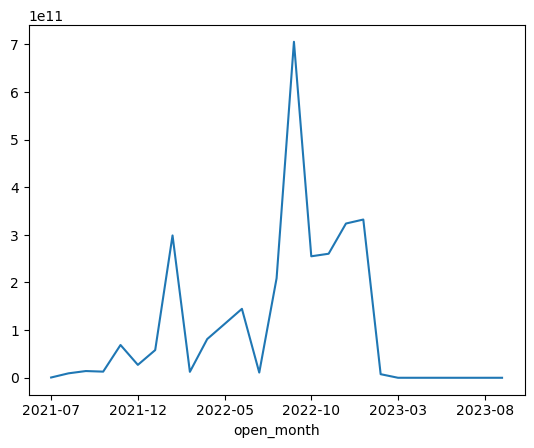

In [153]:
port_01.groupby('open_month').sum()['balance'].sort_index().plot()

<AxesSubplot:xlabel='open_month'>

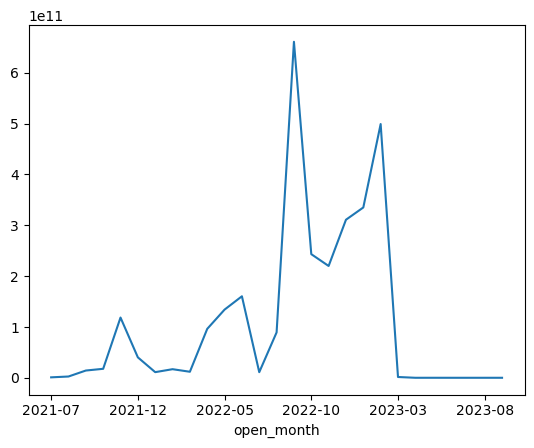

In [154]:
port_02.groupby('open_month').sum()['balance'].sort_index().plot()

In [155]:
import matplotlib.pyplot as plt

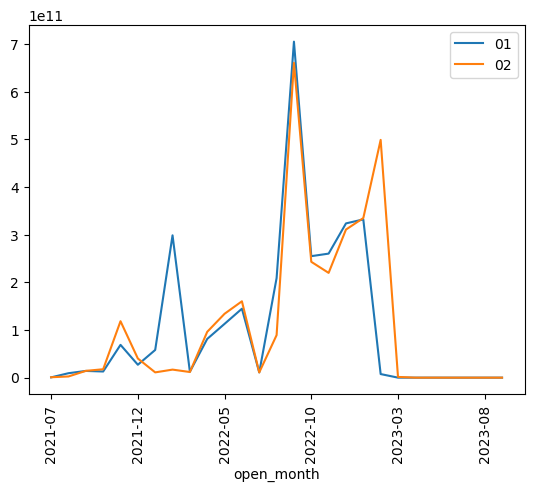

In [156]:
port_01.groupby('open_month').sum()['balance'].sort_index().plot(label='01')
port_02.groupby('open_month').sum()['balance'].sort_index().plot(label='02')
#port_03.groupby('open_month').sum()['balance'].sort_index().plot(label='03')
plt.xticks(rotation=90)
plt.legend()

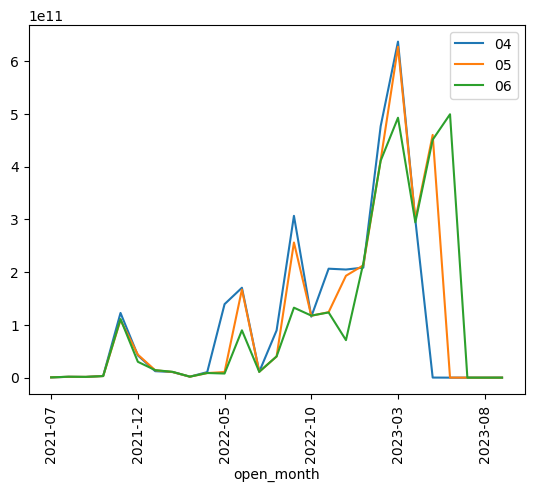

In [157]:
port_04.groupby('open_month').sum()['balance'].sort_index().plot(label='04')
port_05.groupby('open_month').sum()['balance'].sort_index().plot(label='05')
port_06.groupby('open_month').sum()['balance'].sort_index().plot(label='06')

plt.xticks(rotation=90)
plt.legend()

In [158]:
port_04.groupby('open_month').sum()['balance'].sort_index() / 10**9

open_month
2021-07      0.522347
2021-08      1.586428
2021-09      1.320511
2021-10      3.248352
2021-11    122.648671
2021-12     42.218594
2022-01     12.277057
2022-02     10.638817
2022-03      1.879564
2022-04     10.524877
2022-05    139.304831
2022-06    170.397494
2022-07     11.137572
2022-08     89.577380
2022-09    306.670825
2022-10    115.577991
2022-11    206.514030
2022-12    204.939715
2023-01    208.569610
2023-02    476.440505
2023-03    636.813482
2023-04    299.174483
2023-05      0.174670
2023-06      0.020239
2023-07      0.001360
2023-08      0.003721
2023-09      0.034013
Name: balance, dtype: float64

1) Проверить сбор портфеля - возможно собранный за январь 2023 года некорректный  
2) Куда делись открытые депозиты (возможно неправильно заджойнились ставки за февраль 2022 года, вышло где меньше ставка, что некорректно)

In [159]:
port_01.groupby('open_month').sum()['balance'].sort_index() / 10**9

open_month
2021-07      0.614094
2021-08      9.331593
2021-09     14.131178
2021-10     12.896274
2021-11     68.836165
2021-12     27.085326
2022-01     58.145998
2022-02    298.679229
2022-03     12.490886
2022-04     81.285228
2022-05    112.895942
2022-06    144.675446
2022-07     10.949159
2022-08    208.909815
2022-09    705.089563
2022-10    254.948238
2022-11    260.303031
2022-12    323.692025
2023-01    332.084256
2023-02      7.538553
2023-03      0.031487
2023-04      0.000305
2023-05      0.017766
2023-06      0.000170
2023-07      0.001349
2023-08      0.003690
2023-09      0.008650
Name: balance, dtype: float64

In [160]:
port_02.groupby('open_month').sum()['balance_x_ftp'].sort_index() / port_02.groupby('open_month').sum()['balance'].sort_index()

open_month
2021-07     6.959344
2021-08     7.319155
2021-09     7.404844
2021-10     7.790768
2021-11     8.800000
2021-12     9.245455
2022-01     9.562500
2022-02    12.505755
2022-03    21.500000
2022-04    18.121345
2022-05    12.583327
2022-06     9.571405
2022-07     8.756242
2022-08     8.001999
2022-09     7.941635
2022-10     8.392362
2022-11     8.456489
2022-12     8.297449
2023-01     8.554613
2023-02     8.457104
2023-03     8.522878
2023-04     8.246669
2023-05     9.500000
2023-06     9.500000
2023-07     9.642857
2023-08    11.130435
2023-09    12.000000
dtype: float64

In [161]:
port_tmp = port_01[port_01['open_month']=='2022-02']

In [162]:
port_tmp.groupby('target_maturity_days').sum()['balance'] / port_tmp.balance.sum()

target_maturity_days
365     0.979659
548     0.002742
730     0.012307
1095    0.005293
Name: balance, dtype: float64

In [163]:
port_tmp2 = port_01[port_01['open_month']=='2022-03']

In [164]:
port_tmp2.groupby('target_maturity_days').sum()['balance'] / port_tmp2.balance.sum()

target_maturity_days
365     0.878875
548     0.080535
730     0.039900
1095    0.000690
Name: balance, dtype: float64

In [165]:
port_tmp5 = port_05[port_05['open_month']=='2022-09']
port_tmp6 = port_06[port_06['open_month']=='2022-09']

In [166]:
port_tmp5.groupby('target_maturity_days').sum()['balance'] / port_tmp5.balance.sum()

target_maturity_days
365     0.998328
548     0.000786
730     0.000820
1095    0.000065
Name: balance, dtype: float64

In [167]:
port_tmp6.groupby('target_maturity_days').sum()['balance'] / port_tmp6.balance.sum()

target_maturity_days
365     0.996715
548     0.001510
730     0.001649
1095    0.000126
Name: balance, dtype: float64

In [168]:
portfolio_res.target_maturity_days.unique()

array([ 180,  365,   90, 1095,  548,  730])

## Идея - при досрочном отзыве не откатываются проценты по депозитам части клиентов

In [169]:
portfolio_res.groupby('report_dt').sum()['margin_value'].reset_index().T

,0,1,2,3,4,5,6
report_dt,2023-01-31 00:00:00,2023-02-28 00:00:00,2023-03-31 00:00:00,2023-04-30 00:00:00,2023-05-31 00:00:00,2023-06-30 00:00:00,2023-07-31 00:00:00
margin_value,1440538299.066452,1427747648.233747,1296883722.519096,878252268.291305,660436617.182639,532543585.475366,418039713.735082


In [170]:
portfolio_res.columns

Index(['report_month', 'bucketed_balance', 'is_vip_or_prv', 'drop_flg',
       'optional_flg', 'bucketed_period', 'open_month', 'close_month',
       'bucketed_open_rate', 'report_dt', 'total_interests',
       'remaining_interests', 'weight_rate', 'total_generation',
       'total_generation_cleared', 'weight_renewal_cnt',
       'weight_renewal_available_flg', 'weight_close_plan_day', 'gen_name',
       'SER_d', 'SER_d_cl', 'SER_dinamic', 'SER_dinamic_cl',
       'total_generation_lag1', 'total_generation_cl_lag1', 'CUR',
       'report_weight_open_rate_1m', 'report_weight_open_rate_3m',
       'report_weight_open_rate_6m', 'report_weight_open_rate_12m',
       'report_weight_open_rate_24m', 'report_wo_period_weight_open_rate',
       'init_total_generation', 'row_count', 'share_period_plan',
       'max_total_generation', 'max_SER_dinamic', 'replenishable_flg',
       'subtraction_flg', 'segment', 'month_maturity', 'target_maturity_days',
       'bucketed_balance_nm', 'renewal_cnt',

In [171]:
portfolio_res.groupby('report_dt').sum()['SER_d_cl'] / 10**9

report_dt
2023-01-31    -26.471669
2023-02-28     83.763361
2023-03-31    -97.584631
2023-04-30     21.501889
2023-05-31     68.632893
2023-06-30    -11.659184
2023-07-31   -315.613841
Name: SER_d_cl, dtype: float64

In [172]:
portfolio_res.groupby('report_dt').sum()['margin_value'].reset_index().T

,0,1,2,3,4,5,6
report_dt,2023-01-31 00:00:00,2023-02-28 00:00:00,2023-03-31 00:00:00,2023-04-30 00:00:00,2023-05-31 00:00:00,2023-06-30 00:00:00,2023-07-31 00:00:00
margin_value,1440538299.066452,1427747648.233747,1296883722.519096,878252268.291305,660436617.182639,532543585.475366,418039713.735082


In [173]:
#portfolio_res.groupby(['report_dt', 'segment']).sum()['margin_value'].reset_index().sort_values(by=['segment', 'report_dt']).T.to_excel('deposits_res.xlsx')

In [174]:
(portfolio_res.groupby('report_dt').sum()['margin_value'] / portfolio_res.groupby('report_dt').sum()['balance'])*100*10

report_dt
2023-01-31    0.488168
2023-02-28    0.475877
2023-03-31    0.425995
2023-04-30    0.285367
2023-05-31    0.210892
2023-06-30    0.169169
2023-07-31    0.132710
dtype: float64

In [175]:
import seaborn as sns

<AxesSubplot:xlabel='margin_month', ylabel='Density'>

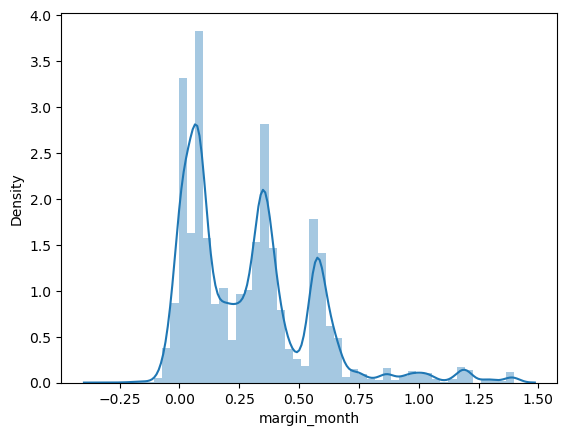

In [176]:
sns.distplot(portfolio_res['margin_month']*100)

<AxesSubplot:xlabel='margin_month', ylabel='Density'>

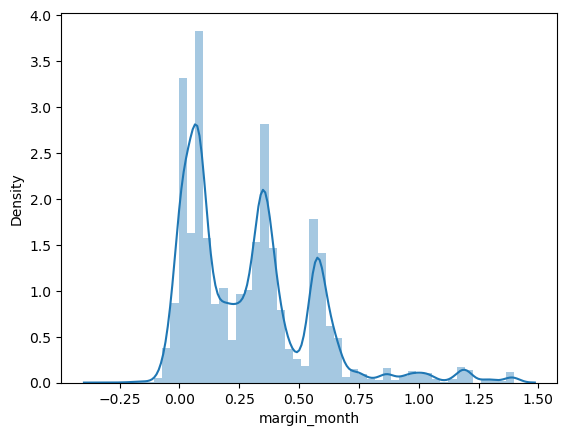

In [177]:
sns.distplot(portfolio_res['margin_month']*100)